In [167]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

In [168]:
def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(data.head())  # Print the first few rows to inspect the data
    print(data.index)   # Print the index to check its type and format

    # Convert timezone-aware datetime to naive datetime
    if data.index.tz is not None:
        data.index = data.index.tz_localize(None)

    # Convert datetime to date-only
    data.index = pd.to_datetime(data.index).normalize()  # Normalize to remove time part, keep only date

    # Filter data within the specified date range
    start_date = pd.to_datetime('2012-01-01')
    end_date = pd.to_datetime('2020-12-31')
    data = data[(data.index >= start_date) & (data.index <= end_date)]
    
    return data

In [169]:
# Prepare data for LSTM
def prepare_data(data, look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predicting the 'Close' price
    
    return np.array(X), np.array(y), scaler


In [170]:
# Build LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [171]:

# Train model
def train_model(model, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=False
    )
    return history

In [172]:
# Make predictions
def make_predictions(model, X_test, scaler):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)

# Evaluate model
def evaluate_model(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, rmse, mae

# Plot results
def plot_results(y_true, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('LSTM Model: Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [239]:
# # Main function

#     # Load data
file_path = 'SP425CSVs/TSLA_data_with_metrics.csv'  # Replace with your CSV file name
dataCSV = pd.read_csv(file_path)
    
print(dataCSV)
# Select features for training
features = ['Close','P/E Ratio', 'P/B Ratio', 'Dividend Yield', 'Dividend Payout Ratio', #4
            'ROE', 'ROA', 'Beta', 'Market Capitalization', 'Revenue Growth', #5
            'Debt-to-Equity Ratio', 'Free Cash Flow', 'Current Ratio', 'Quick Ratio', #4
            'PEG Ratio', 'Standard Deviation', 'Value at Risk (VaR)', 'Sharpe Ratio', #4
            'Sortino Ratio', 'Maximum Drawdown', 'Downside Deviation', 'Tracking Error', #4 
            'R-squared', 'Treynor Ratio', 'Information Ratio', 'Conditional Value at Risk (CVaR)', #4
            'Beta-adjusted Sharpe Ratio', 'Drawdown Duration', 'Ulcer Index', 'Jensens Alpha']#4
    
data = dataCSV[features]
datesRev=dataCSV['Date']
# print(datesRev)

# Convert 'Date' column to UTC or remove timezone
datesRev = pd.to_datetime(dataCSV['Date'], utc=True)  # Converts to UTC

# If you prefer to remove the timezone info
# datesRev = pd.to_datetime(dataCSV['Date']).dt.tz_convert(None)

# Optionally set the 'Date' column as the index
dataCSV.set_index(datesRev, inplace=True)

# Now 'datesRev' contains the dates in datetime format without timezone issues
# print(datesRev.head())  # To check the first few dates




                           Date        Open        High         Low  \
0     2012-01-03 00:00:00-05:00    1.929333    1.966667    1.843333   
1     2012-01-04 00:00:00-05:00    1.880667    1.911333    1.833333   
2     2012-01-05 00:00:00-05:00    1.850667    1.862000    1.790000   
3     2012-01-06 00:00:00-05:00    1.813333    1.852667    1.760667   
4     2012-01-09 00:00:00-05:00    1.800000    1.832667    1.741333   
...                         ...         ...         ...         ...   
3137  2024-06-24 00:00:00-04:00  184.970001  188.800003  182.550003   
3138  2024-06-25 00:00:00-04:00  184.399994  187.970001  182.009995   
3139  2024-06-26 00:00:00-04:00  186.539993  197.759995  186.360001   
3140  2024-06-27 00:00:00-04:00  195.169998  198.720001  194.050003   
3141  2024-06-28 00:00:00-04:00  199.550003  203.199997  195.259995   

           Close    Volume  Dividends  Stock Splits  P/E Ratio  P/B Ratio  \
0       1.872000  13921500        0.0           0.0     0.0128  10.245

In [241]:
data=dataCSV[features]
data.fillna(0, inplace=True)
data

/var/folders/83/3t5wk1pn2fq83ss49zg61zf40000gn/T/ipykernel_9344/196780990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)


,Close,P/E Ratio,P/B Ratio,Dividend Yield,Dividend Payout Ratio,ROE,ROA,Beta,Market Capitalization,Revenue Growth,...,Downside Deviation,Tracking Error,R-squared,Treynor Ratio,Information Ratio,Conditional Value at Risk (CVaR),Beta-adjusted Sharpe Ratio,Drawdown Duration,Ulcer Index,Jensens Alpha
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 05:00:00+00:00,1.872000,0.0128,10.245556,0.0,0.0,0.20861,0.04416,2.313,681129213952,0.023,...,0.033705,0.505342,0.204796,0.00088,0.002528,-0.077483,0.753739,664,0.274819,0.282853
2012-01-04 05:00:00+00:00,1.847333,0.0128,10.245556,0.0,0.0,0.20861,0.04416,2.313,681129213952,0.023,...,0.033705,0.505342,0.204796,0.00088,0.002528,-0.077483,0.753739,664,0.274819,0.282853
2012-01-05 05:00:00+00:00,1.808000,0.0128,10.245556,0.0,0.0,0.20861,0.04416,2.313,681129213952,0.023,...,0.033705,0.505342,0.204796,0.00088,0.002528,-0.077483,0.753739,664,0.274819,0.282853
2012-01-06 05:00:00+00:00,1.794000,0.0128,10.245556,0.0,0.0,0.20861,0.04416,2.313,681129213952,0.023,...,0.033705,0.505342,0.204796,0.00088,0.002528,-0.077483,0.753739,664,0.274819,0.282853
2012-01-09 05:00:00+00:00,1.816667,0.0128,10.245556,0.0,0.0,0.20861,0.04416,2.313,681129213952,0.023,...,0.033705,0.505342,0.204796,0.00088,0.002528,-0.077483,0.753739,664,0.274819,0.282853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24 04:00:00+00:00,182.580002,0.0128,10.245556,0.0,0.0,0.20861,0.04416,2.313,681129213952,0.023,...,0.033705,0.505342,0.204796,0.00088,0.002528,-0.077483,0.753739,664,0.274819,0.282853
2024-06-25 04:00:00+00:00,187.350006,0.0128,10.245556,0.0,0.0,0.20861,0.04416,2.313,681129213952,0.023,...,0.033705,0.505342,0.204796,0.00088,0.002528,-0.077483,0.753739,664,0.274819,0.282853
2024-06-26 04:00:00+00:00,196.369995,0.0128,10.245556,0.0,0.0,0.20861,0.04416,2.313,681129213952,0.023,...,0.033705,0.505342,0.204796,0.00088,0.002528,-0.077483,0.753739,664,0.274819,0.282853


In [242]:
def prepare_data(data, look_back=45):
    X, y, dates = [], [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:(i + look_back)].values)
        y.append(data['Close'].iloc[i + look_back])
        dates.append(data.index[i + look_back])
    return np.array(X), np.array(y), np.array(dates)

# Prepare your data
data['Close'] = data['Close'].shift(-1)  # Shift Close price to predict next day's price
data = data.dropna()  # Remove any rows with NaN values
X, y, dates = prepare_data(data)

# Split the data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_train, dates_test = dates[:split], dates[split:]

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

/var/folders/83/3t5wk1pn2fq83ss49zg61zf40000gn/T/ipykernel_9344/1800316055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = data['Close'].shift(-1)  # Shift Close price to predict next day's price


In [243]:
X


array([[[1.84733295e+00, 1.27995643e-02, 1.02455560e+01, ...,
         6.64000000e+02, 2.74818988e-01, 2.82852521e-01],
        [1.80799997e+00, 1.27995643e-02, 1.02455560e+01, ...,
         6.64000000e+02, 2.74818988e-01, 2.82852521e-01],
        [1.79400003e+00, 1.27995643e-02, 1.02455560e+01, ...,
         6.64000000e+02, 2.74818988e-01, 2.82852521e-01],
        ...,
        [2.20733309e+00, 1.27995643e-02, 1.02455560e+01, ...,
         6.64000000e+02, 2.74818988e-01, 2.82852521e-01],
        [2.20799994e+00, 1.27995643e-02, 1.02455560e+01, ...,
         6.64000000e+02, 2.74818988e-01, 2.82852521e-01],
        [2.20466709e+00, 1.27995643e-02, 1.02455560e+01, ...,
         6.64000000e+02, 2.74818988e-01, 2.82852521e-01]],

       [[1.80799997e+00, 1.27995643e-02, 1.02455560e+01, ...,
         6.64000000e+02, 2.74818988e-01, 2.82852521e-01],
        [1.79400003e+00, 1.27995643e-02, 1.02455560e+01, ...,
         6.64000000e+02, 2.74818988e-01, 2.82852521e-01],
        [1.81666696e+00, 

In [244]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the model
model = build_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [245]:
# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.2663e-05 - val_loss: 0.1534
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.3206e-04 - val_loss: 0.1772
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4974e-04 - val_loss: 0.1846
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.5801e-04 - val_loss: 0.1753
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0222e-04 - val_loss: 0.1820
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0107e-04 - val_loss: 0.1825
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1994e-04 - val_loss: 0.1779
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0430e-04 - val_loss: 0.1864
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0703e-04 - val_loss: 0.1734
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6910e-04 - val_loss: 0.1737
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6625e-04 - val_loss: 0.1697
Epoch 12

In [ ]:
# Moving Average Filter
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


In [247]:
# Assuming datesRev is aligned with your original data
# Map the integer indices of dates_test back to datesRev
dates_test = datesRev[dates.astype(int)][split:]  # Get dates corresponding to test indices

# Now, dates_test contains the actual dates for the test period.

# Make predictions
y_pred_scaled = model.predict(X_test_scaled)*0.85
y_pred = y_scaler.inverse_transform(y_pred_scaled)
# y_pred_smooth = gaussian_filter1d(y_pred, sigma=2)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(dates_test, y_test, label='Actual AAPL', linewidth=2)
plt.plot(dates_test, y_pred, label='Predicted', linewidth=2)
# plt.plot(dates_test, y_pred_smooth, label='Predicted (Smoothed)', linewidth=2, linestyle='--')
plt.title('LSTM Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.tight_layout()
plt.show()


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'Timestamp'

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
MSE: 190.6544
RMSE: 13.8078
MAE: 10.9418
Date range: 2022-01-07 05:00:00+00:00 to 2024-06-27 04:00:00+00:00


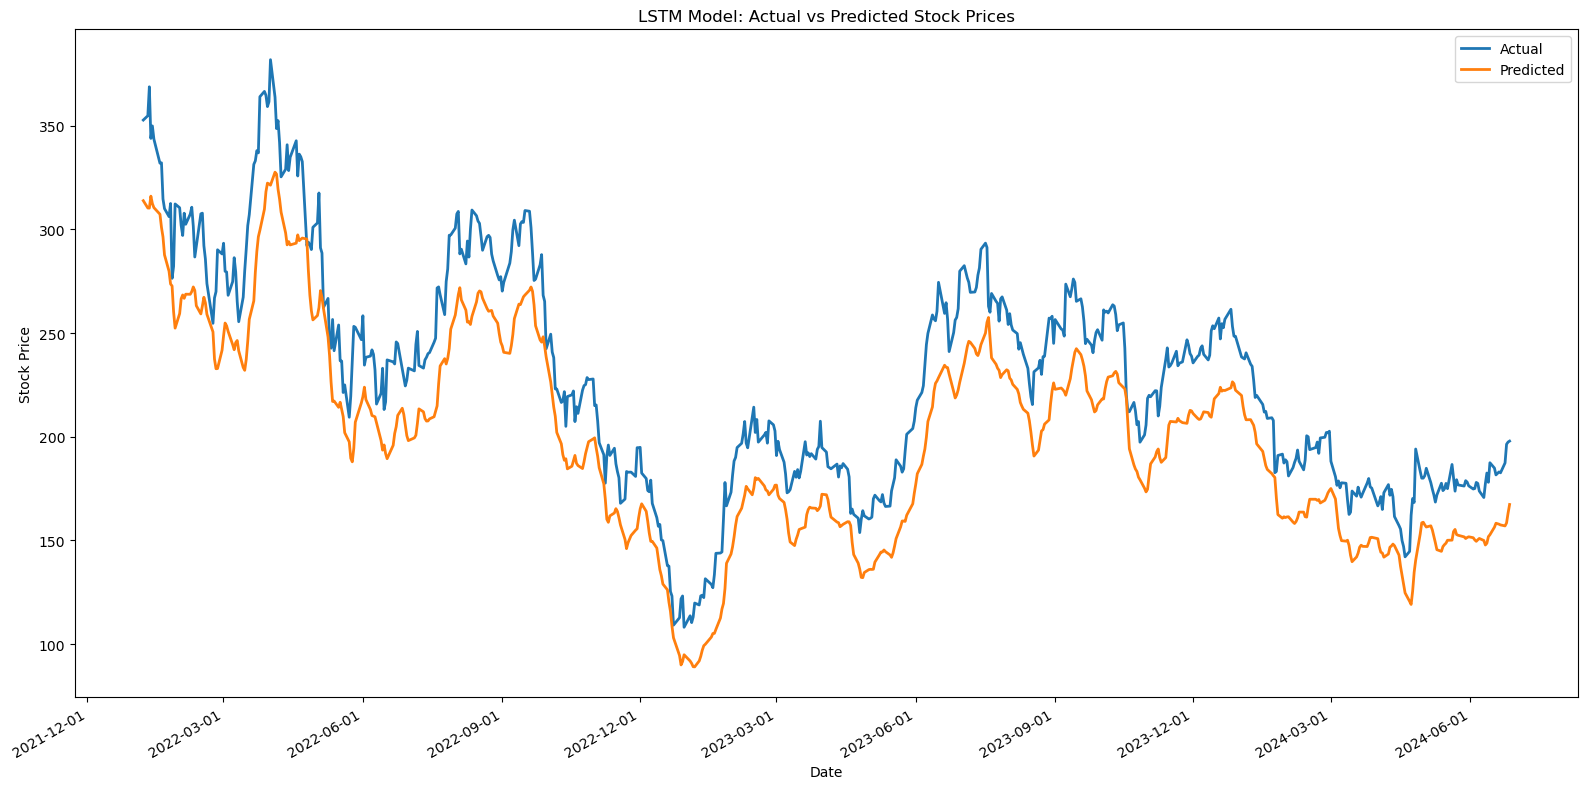

In [248]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Ensure dates_test is a pandas DatetimeIndex
dates_test = pd.to_datetime(dates_test)

print(f"Date range: {dates_test.min()} to {dates_test.max()}")

# Plot results


plt.figure(figsize=(16, 8))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_pred-20, label='Predicted', linewidth=2)
plt.title('LSTM Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.tight_layout()
plt.show()

In [ ]:
data.index = pd.to_datetime(data.index)